In [1]:
def main():
    path='../'
    train_df = pd.read_csv(path+'train_translated.csv')
    test_df = pd.read_csv(path+'test_translated.csv')
    df = pd.concat([train_df, test_df],axis=0,ignore_index=True)
    df['text_id'] = df['id']
    df.drop(columns=['id'], inplace=True)
    k = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)
    epoch_num=45
    
    #languages = ['description','translate_de', 'translate_es', 'translate_fr', 'translate_ja']
    languages = ['description', 'translate_es','translate_ja']
    
    test_dic={}
    loss_dic={}
    for language in languages:
        test_dic[language]={}
        loss_dic[language]={}
        
        train_df, test_df, mlp_feature = make_tfidf_df(df, language)
        alltarget_trnpred = Alltarget_Train_Predict(train_df, test_df, mlp_feature, hidden_layers=[300, 100], lr=0.0006)
        all_test_df, all_trn_loss_list = alltarget_trnpred.predict_test_df(epoch_num)
        
        preds_cols = [col for col  in all_test_df.columns if 'p_' in col] 
        test_dic[language]['all'] = all_test_df[preds_cols].rename(columns={col:f'{language}_{col}' for col in preds_cols})
        loss_dic[language]['all'] = all_trn_loss_list
        
        onetarget_trnpred = Onetarget_Train_Predict(train_df, test_df, mlp_feature, hidden_layers=[300, 100], lr=0.0006)
        one_test_data=[]
        for label in [1,2,3,4]:
            one_test_df, one_trn_loss_list = onetarget_trnpred.predict_test_df(label, epoch_num)
            preds_cols = [col for col  in one_test_df.columns if 'p_' in col] 
            one_test_data.append(one_test_df[preds_cols].rename(columns={col:f'{language}_{col}' for col in preds_cols}))
            loss_dic[language][f'{label}'] = one_trn_loss_list
            
            
        test_dic[language]['one'] = pd.concat(one_test_data, axis=1)
    
    return test_dic, loss_dic

In [2]:
import  warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, KFold, ShuffleSplit
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.utils.data
import torchvision
from torch import optim
from torch import cuda
from torch.optim.lr_scheduler import CosineAnnealingLR

import time, gc, random
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from stop_words import get_stop_words
import nltk, string
from nltk.stem.porter import PorterStemmer

import lightgbm as lgb

random.seed(2020)
np.random.seed(2020)
torch.cuda.manual_seed_all(2020)

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from Preprocessing import make_tfidf_df
from one_target import Train_Predict as Onetarget_Train_Predict
from all_target import Train_Predict as Alltarget_Train_Predict
from cv import cv, main

In [4]:
%%time
off_dic, off_loss_dic = cv()


Wall time: 16min 13s


In [5]:
import pickle
with open('off_dic.pickle', 'wb') as f:
    pickle.dump(off_dic, f)
    
with open('off_loss_dic.pickle', 'wb') as f:
    pickle.dump(off_loss_dic, f)

In [6]:
%%time
test_dic, test_loss_dic = main()


Wall time: 13min 23s


In [7]:
import pickle
with open('test_dic.pickle', 'wb') as f:
    pickle.dump(test_dic, f)
    
import pickle
with open('test_loss_dic.pickle', 'wb') as f:
    pickle.dump(test_loss_dic, f)

In [8]:
"""
import pickle
with open('test_dic.pickle', 'wb') as f:
    pickle.dump(test_dic, f)
with open('singer.pickle', 'rb') as f:
    singer = pickle.load(f)"""

"\nimport pickle\nwith open('test_dic.pickle', 'wb') as f:\n    pickle.dump(test_dic, f)\nwith open('singer.pickle', 'rb') as f:\n    singer = pickle.load(f)"

In [15]:
off_loss_dic['description'].keys()

dict_keys(['cv_loss', 'cv_score', 'one_cv_loss_1', 'one_cv_score_1', 'one_cv_loss_2', 'one_cv_score_2', 'one_cv_loss_3', 'one_cv_score_3', 'one_cv_loss_4', 'one_cv_score_4'])

cv_loss


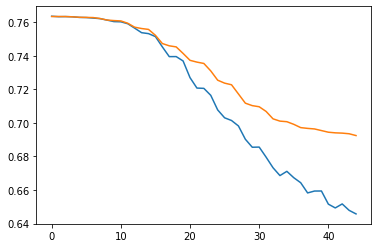

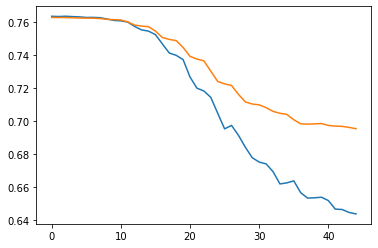

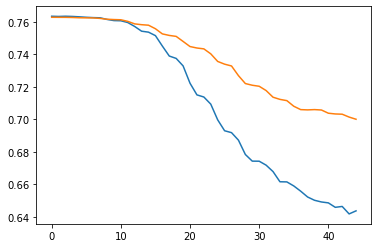

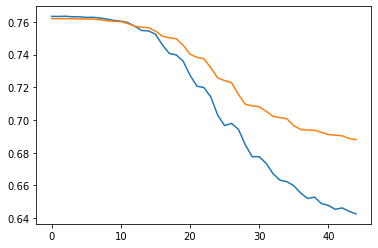

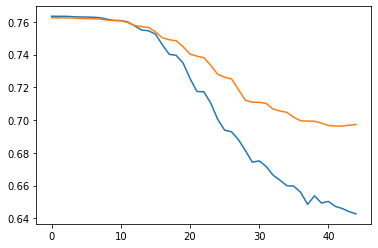

cv_score


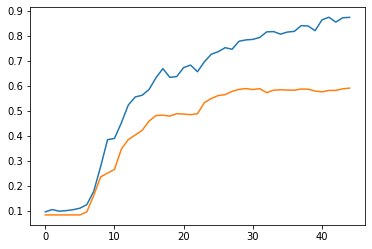

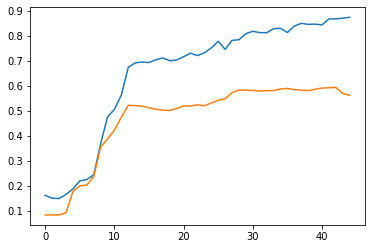

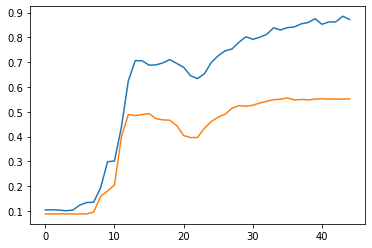

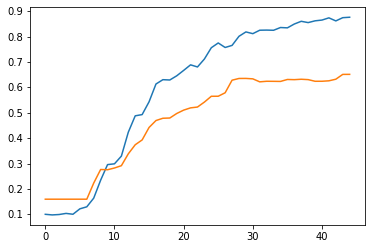

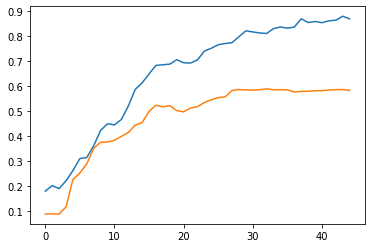

one_cv_loss_1


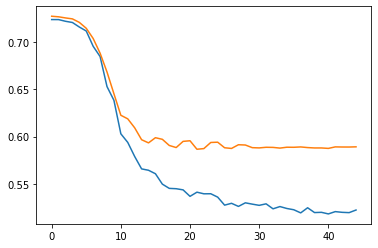

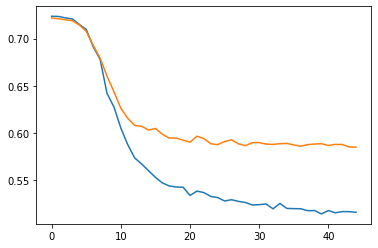

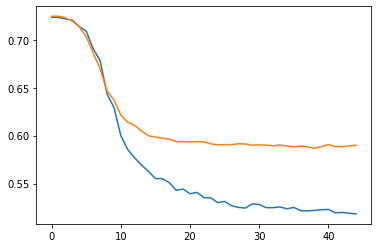

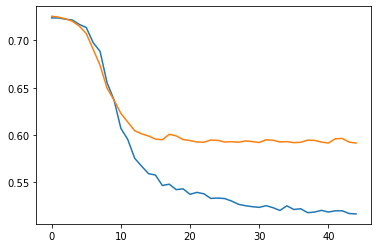

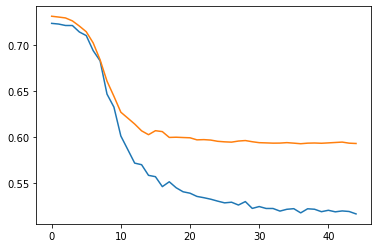

one_cv_score_1


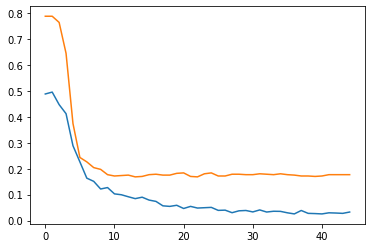

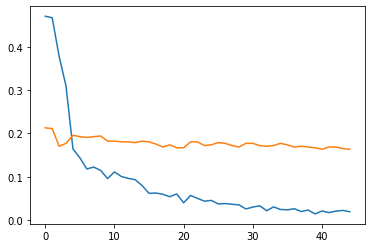

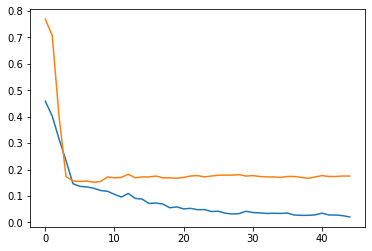

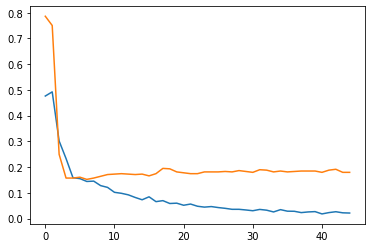

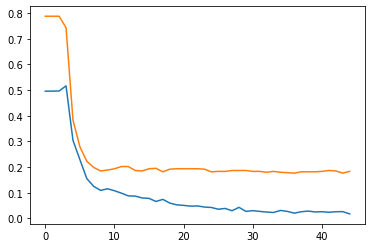

one_cv_loss_2


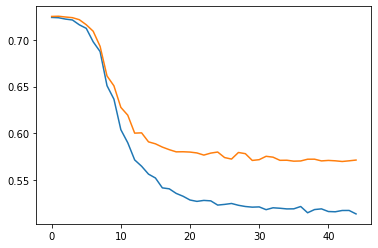

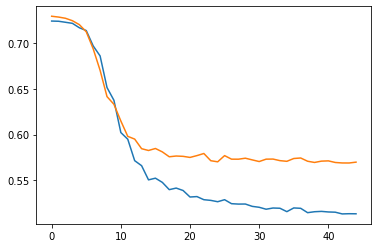

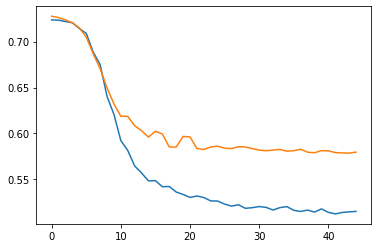

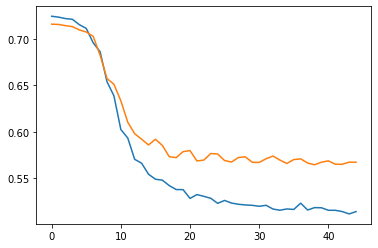

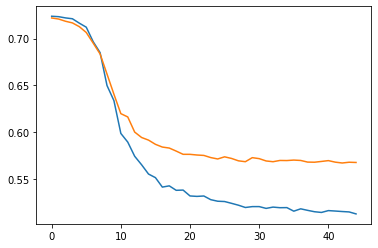

one_cv_score_2


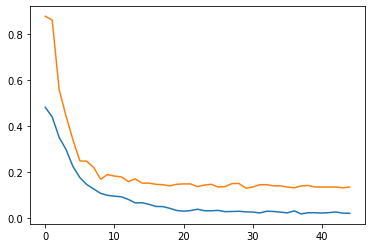

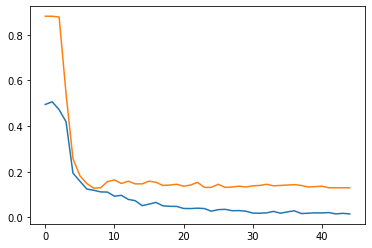

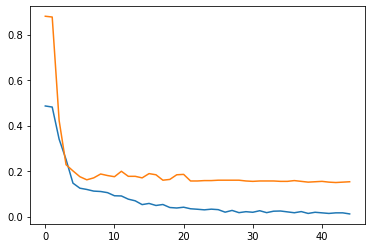

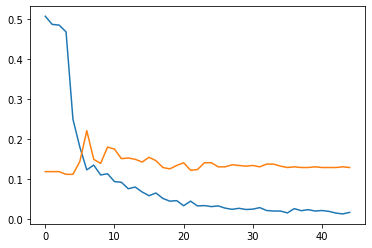

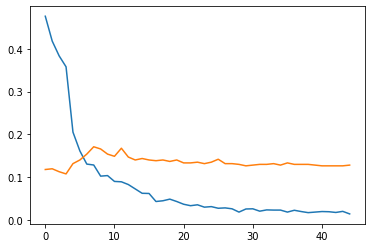

one_cv_loss_3


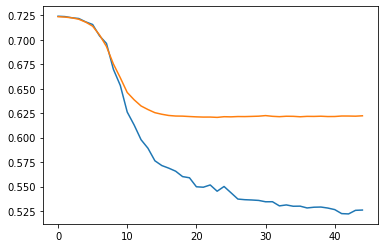

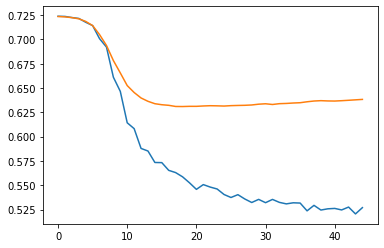

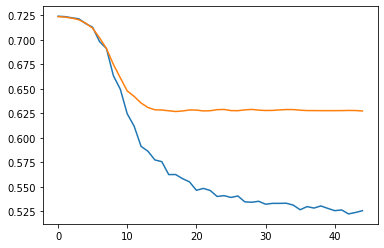

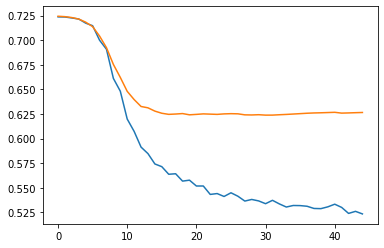

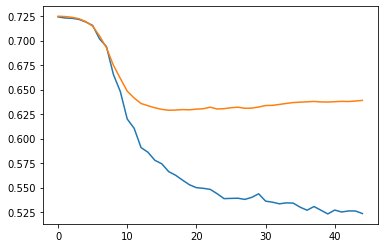

one_cv_score_3


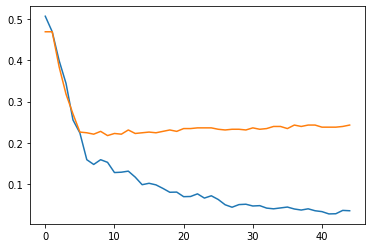

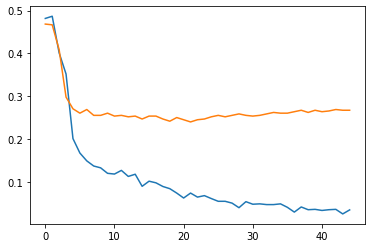

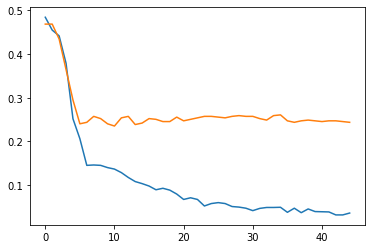

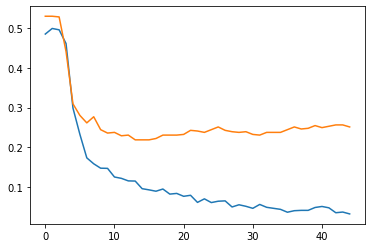

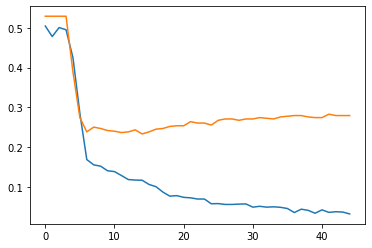

one_cv_loss_4


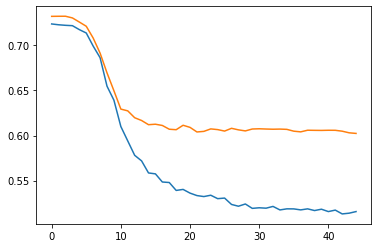

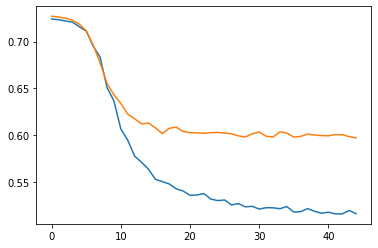

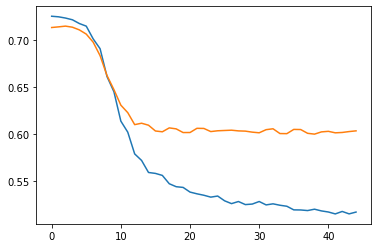

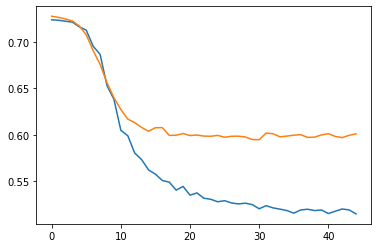

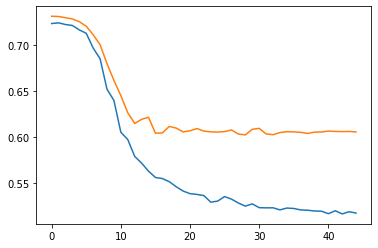

one_cv_score_4


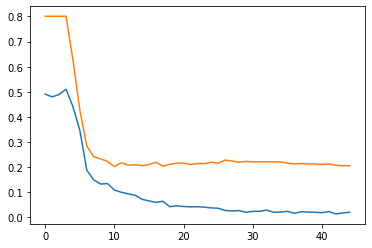

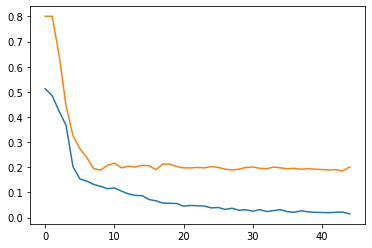

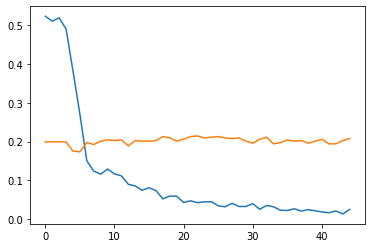

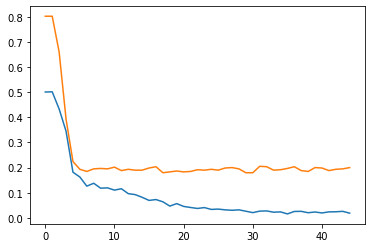

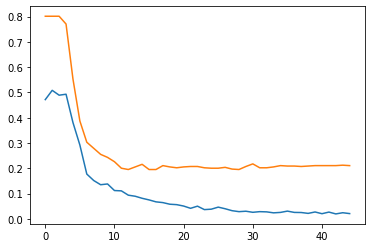

In [22]:
for key in off_loss_dic['description'].keys():
    print(key)
        
    for score in off_loss_dic['description'][key]:
        plt.plot(score[0])
        plt.plot(score[1])    
        plt.show()

In [24]:

off_dic['description']['all']

description_text_id  description_jobflag  description_p_1_0  \
0                       0                  2.0           0.271013   
1                       1                  3.0           0.235942   
2                       2                  4.0           0.263899   
3                       3                  1.0           0.225933   
4                       4                  4.0           0.270939   
...                   ...                  ...                ...   
2926                 2926                  3.0           0.225548   
2927                 2927                  3.0           0.236089   
2928                 2928                  1.0           0.235473   
2929                 2929                  3.0           0.238861   
2930                 2930                  2.0           0.264574   

      description_p_2_0  description_p_3_0  description_p_4_0  \
0              0.239066           0.256209           0.233711   
1              0.240007           0.258572           0.265478   
2              0.220143           0.254666           0.261292   
3              0.253683           0.273302           0.247082   
4              0.238747           0.256130           0.234183   
...                 ...                ...                ...   
2926           0.254516           0.273613           0.246324   
2927           0.239720           0.258600           0.265590   
2928           0.239630           0.259067           0.265829   
2929           0.241342           0.248314           0.271483   
2930           0.219770           0.254124           0.261531   

      description_p_1_1  description_p_2_1  description_p_3_1  \
0              0.270963           0.239022           0.256442   
1              0.236195           0.239703           0.258852   
2              0.263665           0.220223           0.254746   
3              0.226017           0.253972           0.272880   
4              0.270997           0.238641           0.256264   
...                 ...                ...                ...   
2926           0.225530           0.254946           0.273281   
2927           0.236362           0.239326           0.258810   
2928           0.235802           0.239309           0.259196   
2929           0.239356           0.241609           0.248174   
2930           0.264582           0.219946           0.254131   

      description_p_4_1  ...  description_p_3_42  description_p_4_42  \
0              0.233573  ...            0.915133            0.009845   
1              0.265250  ...            0.937525            0.037978   
2              0.261366  ...            0.122282            0.865439   
3              0.247130  ...            0.047454            0.401635   
4              0.234098  ...            0.369566            0.593382   
...                 ...  ...                 ...                 ...   
2926           0.246243  ...            0.502993            0.132138   
2927           0.265501  ...            0.222804            0.747866   
2928           0.265693  ...            0.083187            0.832887   
2929           0.270860  ...            0.963161            0.025080   
2930           0.261341  ...            0.002522            0.003173   

      description_p_1_43  description_p_2_43  description_p_3_43  \
0               0.002679            0.057298            0.932881   
1               0.005049            0.013282            0.947663   
2               0.010226            0.001522            0.100284   
3               0.577169            0.008787            0.041486   
4               0.021277            0.012760            0.393775   
...                  ...                 ...                 ...   
2926            0.190510            0.158009            0.538802   
2927            0.026042            0.003543            0.200630   
2928            0.060598            0.017337            0.065878   
2929            0.000373            0.010136            0.968321   
29